# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [3]:
dat = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1", na_values = '-999').rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})



dat.drop(columns=['HabitatBreadth', 'ActivityCycle', 'ForagingStratum', 'GestationLength', 'LitterSize',
                 'InterbirthInterval', 'HomeRange', 'PopulationDensity', 'SocialGrpSize', 'Longevity'])


dat = dat.loc[:, dat.isnull().sum() < 0.4*dat.shape[0]]
print(dat.dtypes)

dat.head()

AdultBodyMass         float64
Diet_Invertebrates     object
Diet_Vertebrates       object
Diet_Fruits            object
Diet_Flowers           object
Diet_Seeds             object
Diet_Plants            object
Diet_Other             object
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
Dry                     int64
Humid                   int64
Montane                 int64
Subarid                 int64
Subhumid                int64
dtype: object


,AdultBodyMass,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid
0,78.0,yes,no,yes,yes,no,yes,no,1.0,2.0,3.0,1.00,0,1,1,0,1
1,1082.0,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,0,1,0,0,1
2,946.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,NaN,1,0,0,0,0
3,1180.0,no,no,yes,no,no,yes,no,2.0,1.0,3.0,1.01,1,1,1,0,1
4,1212.5,no,no,yes,no,no,yes,no,1.0,1.0,3.0,NaN,0,1,0,1,1


In [4]:
print("Before imputing categorical variables:", dat.select_dtypes(include=['object']).isna().sum())

# Separate categorical and numerical columns
cat_cols = dat.select_dtypes(include=['object']).columns
num_cols = dat.select_dtypes(include=['number']).columns

# Impute categorical variables (mode)
cat_imputed = dat[cat_cols].fillna(dat[cat_cols].mode().iloc[0])


# Check to make sure there are no NAs
print(cat_imputed.isna().sum())

print(f"Final DataFrame shape: ", dat.shape)


Before imputing categorical variables: Diet_Invertebrates    15
Diet_Vertebrates      15
Diet_Fruits           15
Diet_Flowers          15
Diet_Seeds            15
Diet_Plants           15
Diet_Other            15
dtype: int64
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
dtype: int64
Final DataFrame shape:  (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [5]:
# Impute with KNN Imputer
knn_impute = KNNImputer(n_neighbors = 5)

# impute the numeric cols in dat dataframe, note that dat_knn_impute is a numpy array
dat_knn_impute = knn_impute.fit_transform(dat[num_cols])

# Create a new dataframe with the new imputed numeric values with the same columns and indices
num_imputed_df = pd.DataFrame(dat_knn_impute, columns=num_cols, index=dat.index)

# Concatenate imputed categorical and numerical data
df_imputed = pd.concat([cat_imputed, num_imputed_df], axis=1)

# Check to make sure there are no NAs
df_imputed.isna().sum()

Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
AdultBodyMass         0
HabitatBreadth        0
ActivityCycle         0
ForagingStratum       0
LitterSize            0
Dry                   0
Humid                 0
Montane               0
Subarid               0
Subhumid              0
dtype: int64

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [6]:
df_imputed.head()

,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,Dry,Humid,Montane,Subarid,Subhumid
0,yes,no,yes,yes,no,yes,no,78.0,1.0,2.0,3.0,1.000,0.0,1.0,1.0,0.0,1.0
1,no,no,yes,no,no,yes,no,1082.0,1.0,1.0,3.0,1.402,0.0,1.0,0.0,0.0,1.0
2,no,no,yes,no,no,yes,no,946.0,2.0,1.0,3.0,4.692,1.0,0.0,0.0,0.0,0.0
3,no,no,yes,no,no,yes,no,1180.0,2.0,1.0,3.0,1.010,1.0,1.0,1.0,0.0,1.0
4,no,no,yes,no,no,yes,no,1212.5,1.0,1.0,3.0,1.540,0.0,1.0,0.0,1.0,1.0


In [7]:
# Initialize new column nClimates
df_imputed['nClimates'] = 0

# Sum the occurences in each climate and aggregate this into nClimate col
df_imputed['nClimates'] = df_imputed[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)
    
# Drop the climate columns now that we have our nClimate
df_imputed.drop(columns = ['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'], inplace= True)

# Check dataframe
df_imputed.head()

,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,AdultBodyMass,HabitatBreadth,ActivityCycle,ForagingStratum,LitterSize,nClimates
0,yes,no,yes,yes,no,yes,no,78.0,1.0,2.0,3.0,1.000,3.0
1,no,no,yes,no,no,yes,no,1082.0,1.0,1.0,3.0,1.402,2.0
2,no,no,yes,no,no,yes,no,946.0,2.0,1.0,3.0,4.692,1.0
3,no,no,yes,no,no,yes,no,1180.0,2.0,1.0,3.0,1.010,4.0
4,no,no,yes,no,no,yes,no,1212.5,1.0,1.0,3.0,1.540,3.0


In [8]:
# Encode categorical variables with for loop

for col in df_imputed.select_dtypes(include=['object']):
    label_encoded = LabelEncoder()
    df_imputed[col] = label_encoded.fit_transform(df_imputed[col])    # returns binary code for object dtype columns

# Split data into train and test
X = df_imputed.drop(['nClimates'], axis = 1)
y = df_imputed['nClimates']

print(X.columns)
print(X.head())
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 808, test_size = .3)

Index(['Diet_Invertebrates', 'Diet_Vertebrates', 'Diet_Fruits', 'Diet_Flowers',
       'Diet_Seeds', 'Diet_Plants', 'Diet_Other', 'AdultBodyMass',
       'HabitatBreadth', 'ActivityCycle', 'ForagingStratum', 'LitterSize'],
      dtype='object')
   Diet_Invertebrates  Diet_Vertebrates  Diet_Fruits  Diet_Flowers  \
0                   1                 0            1             1   
1                   0                 0            1             0   
2                   0                 0            1             0   
3                   0                 0            1             0   
4                   0                 0            1             0   

   Diet_Seeds  Diet_Plants  Diet_Other  AdultBodyMass  HabitatBreadth  \
0           0            1           0           78.0             1.0   
1           0            1           0         1082.0             1.0   
2           0            1           0          946.0             2.0   
3           0            1           0    

### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

In [9]:
# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth = 5, 
                           random_state = 808)

# Train model
dt.fit(X_train, y_train)

# Predict model
y_pred = dt.predict(X_test)

# Plot decision tree
plt.figure(figsize = (12,15), dpi = 700)
plot_tree(dt, feature_names = X.columns, filled = True)
plt.title('Decision Tree with a max depth of 5')
plt.savefig('decision_tree.png')
plt.show()

# Evaluate MSE
mse = mean_squared_error(y_test, y_pred)

print(f"MSE performance: {mse}")

MSE performance: 2.0447678987569176


Based on the way this tree looks, what would you guess the most important variable to be?

I would guess that Diet_Plants is the most important variable in this decision tree because it is the split at the first node. 

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [26]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_features': ['sqrt', 6, None],  # Number of features to consider at each split
    'max_depth': [3, 4, 5, 6, 7],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Initalize Random Forest 
rf = RandomForestRegressor(random_state=808)

# Grid search with cross-validation (cv=5 folds)
gs = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Train random forest 
gs.fit(X_train, y_train)

# Train the best estimator
best_rf = RandomForestRegressor(**gs.best_params_, random_state = 808)
best_rf.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=808)

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [28]:
# Generate predictions from best rf
y_pred_best = best_rf.predict(X_test)

# Print best parameters and MSE
print(f"Best Parameters: {gs.best_params_}")
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"\nRF Regressor MSE: {mse_best:.3f}")

# Extract feature importance from Random Forest
importance = best_rf.feature_importances_

# Create list of feature names
feature_names = X_train.columns

# Create feature importance df
importance_df = (pd.DataFrame(zip(feature_names, importance), columns=['Feature', 'Importance'])
                 .sort_values(by = 'Importance', key = abs, ascending = False)
                 .reset_index(drop=True))

# Print the sorted feature importance
print("\nFeature Importances:\n", importance_df)


Best Parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

RF Regressor MSE: 1.468

Feature Importances:
                Feature  Importance
0        AdultBodyMass    0.277929
1           LitterSize    0.185691
2      ForagingStratum    0.120465
3        ActivityCycle    0.083299
4          Diet_Plants    0.083038
5       HabitatBreadth    0.064288
6     Diet_Vertebrates    0.037214
7          Diet_Fruits    0.035008
8   Diet_Invertebrates    0.031821
9         Diet_Flowers    0.031139
10          Diet_Seeds    0.030045
11          Diet_Other    0.020064


Text(0.5, 1.0, 'Random Forest Feature Importance')

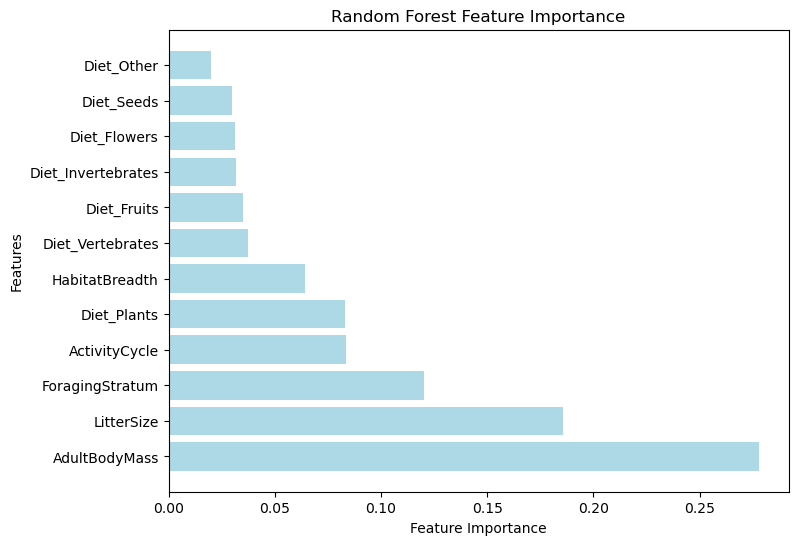

In [31]:
#Visualize the features

plt.figure(figsize=(8,6))

plt.barh(y=importance_df['Feature'], width=importance_df['Importance'], color="lightblue")

plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

In [32]:
print(f"Single Tree MSE: {mse:.3f}")
print(f"Ensemble MSE: {mse_best:.3f}")

Single Tree MSE: 2.045
Ensemble MSE: 1.468


The random forest ensemble mean squared error is lower than the single tree MSE, indicating better accuracy. Adult body mass seems to have the most influence on species' climate adaptability, but I am not sure why. 